In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np
import torch
sys.path.append(".")
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from datasets import load_dataset
from accelerate import Accelerator
from torch.utils.data import DataLoader
from utils.template import TEMPLATE_DICT
import json
import pandas as pd

/home/gabriel.talasso/FT_LLM_FL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-10-01 16:23:15,401] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
template = TEMPLATE_DICT['alpaca'][0]
MODEL_NAME = 'TinyLlama/TinyLlama_v1.1'
DATASET_NAME = "CohereForAI/aya_dataset"
DEVICE = 'cuda:0'
EVALSET_LEN = 10

In [3]:
path = 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-200'

In [4]:
def load_model(path, MODEL_NAME, DEVICE):
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16,
                                                    quantization_config = BitsAndBytesConfig(
                                                                            load_in_4bit=True,
                                                                            bnb_4bit_use_double_quant=True,
                                                                            bnb_4bit_quant_type="nf4",
                                                                            bnb_4bit_compute_dtype=torch.bfloat16,
                                                                        ),
                                                    device_map={"": Accelerator().local_process_index})

    model = PeftModel.from_pretrained(model, path).to(DEVICE)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, device=DEVICE, use_fast=False, padding_side="right")
    tokenizer.pad_token = tokenizer.unk_token

    return model, tokenizer

model, tokenizer = load_model(path, MODEL_NAME, DEVICE)

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

In [5]:
def load_eval_data(DATASET_NAME, EVALSET_LEN, languages):
    
    dataset = load_dataset(DATASET_NAME, split="train", )
    dataset = dataset.filter(lambda x: x['language'] in ['English', 'Swedish', 'German', 'Portuguese', 'Spanish'])
    dataset_splited = dataset.train_test_split(test_size= 0.2, seed=0)
    dataset_test = dataset_splited['test']
    dataset = dataset_test.filter(lambda x: x['language'] in languages)
    dataset_len = min(len(dataset), EVALSET_LEN)
    dataset = dataset.select(range(dataset_len))

    return dataset

In [6]:
def tokenize_function(examples):
    inputs = tokenizer(examples["inputs"],   padding="max_length", truncation=True, return_tensors="pt", max_length=512)
    targets = tokenizer(examples["targets"], padding="max_length", truncation=True, return_tensors="pt", max_length=512)
    return {
        "input_ids": inputs["input_ids"].squeeze(),
        "attention_mask": inputs["attention_mask"].squeeze(),
        "labels": targets["input_ids"].squeeze()
    }

In [7]:
test_dataset = load_eval_data(DATASET_NAME, EVALSET_LEN, ['English'])

Found cached dataset parquet (/home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
Loading cached processed dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-a43a64b8b3c754cd.arrow
Loading cached split indices for dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-cca2a273063fd6b6.arrow and /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc36655ce556/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-d0cf8b2e0da0987b.arrow
Loading cached processed dataset at /home/gabriel.talasso/.cache/huggingface/datasets/CohereForAI___parquet/default-dc0ecc3665

In [8]:
import torch
from tqdm import tqdm
import numpy as np

def format_instruction(instruction, response, eos):
    template = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{} 

### Response: {}{}"""

    return template.format(instruction, response, eos)

def calculate_perplexity(model, tokenizer, dataset, max_length=512):
    model.eval()
    total_loss = 0
    total_length = 0

    with torch.no_grad():
        for item in tqdm(dataset):
            # Format the input as an instruction
            input_text = format_instruction(item['inputs'], item['targets'], tokenizer.eos_token)

            encodings = tokenizer(input_text, return_tensors='pt', truncation=True, max_length=max_length)
            input_ids = encodings.input_ids.to(model.device)
            target_ids = input_ids.clone()
            
            #print(input_text)
            #print(input_ids)
            
            outputs = model(input_ids, labels=target_ids)
            loss = outputs.loss

            #input_text = format_instruction(item['inputs'], '', '')
            #input_ids = tokenizer(input_text, return_tensors='pt', truncation=True, max_length=max_length)
            #outputs_ids = model.generate(**input_ids, max_length=512, num_beams=8, no_repeat_ngram_size=3, early_stopping=True)
            #outputs_text = tokenizer.decode(outputs_ids[0], skip_special_tokens=True)
            #print(outputs_text)
            
            total_loss += loss.item()

    return torch.exp(torch.tensor(total_loss/ len(dataset)))

In [9]:
#calculate_perplexity(model, tokenizer, test_dataset)

In [10]:
#perplexity round 1 em pt br: 22.7364
#perplexity round 25 em pt br: 23.4307

In [11]:
def calculate_completion_perplexity(model, tokenizer, dataset, device, max_length=512):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for item in tqdm(dataset):
            # Format the prompt
            prompt = format_instruction(item['inputs'], '', '')
            
            # Tokenize the prompt
            prompt_ids = tokenizer(prompt, return_tensors='pt').to(device)
            
            # Generate completion
            output_ids = model.generate(**prompt_ids, max_length=max_length, num_return_sequences=1)

            print(tokenizer.decode(output_ids[0], skip_special_tokens=True))
            #expected response
            #print(item['targets'])
            
            # Extract only the completion part
            completion_ids = output_ids[0][prompt_ids['input_ids'].shape[1]:]

            
            # Prepare input for loss calculation
            input_ids = completion_ids[:-1].unsqueeze(0)
            #target_ids = completion_ids[1:].unsqueeze(0)

            target_ids = tokenizer(item['targets'], return_tensors='pt', max_length=max_length, padding='max_length').to(device)['input_ids']
            print(item['targets'])

            #make target and inputs the same length
            if target_ids.shape[1] > input_ids.shape[1]:
                target_ids = target_ids[:, :input_ids.shape[1]]
            else:
                input_ids = input_ids[:, :target_ids.shape[1]]
            
            # Calculate loss
            outputs = model(input_ids, labels=target_ids)
            loss = outputs.loss
            
            total_loss += loss.item() 
            print('Loss:', loss.item())

    avg_loss = total_loss / len(dataset)
    perplexity = torch.exp(torch.tensor(avg_loss))
    
    return perplexity.item()

In [12]:
#calculate_completion_perplexity(model, tokenizer, test_dataset, DEVICE)

In [13]:
def calculate_ground_truth_perplexity(model, tokenizer, dataset, device, max_length=512):
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for item in tqdm(dataset):
            # Format the prompt
            prompt = format_instruction(item['inputs'], '', '')
            ground_truth = item['targets']
            
            # Combine prompt and ground truth
            full_text = prompt + ground_truth
            
            # Tokenize the full text
            encodings = tokenizer(full_text, return_tensors='pt', truncation=True, max_length=max_length)
            input_ids = encodings.input_ids.to(device)
            
            # Prepare input for loss calculation
            target_ids = input_ids.clone()
            
            # Calculate loss only on the ground truth part
            prompt_length = len(tokenizer.encode(prompt)) - 1  # -1 to not count the last token twice
            outputs = model(input_ids, labels=target_ids)
            loss = outputs.loss
            
            total_loss += loss.item()
            
            #print('Loss:', loss.item())

    avg_loss = total_loss / len(dataset)
    perplexity = torch.exp(torch.tensor(avg_loss))
    
    return perplexity.item()

In [14]:
#calculate_ground_truth_perplexity(model, tokenizer, test_dataset, DEVICE)

In [15]:
def make_completions(model, tokenizer, dataset, device, max_length=512, model_name='checkpoint'):

    df = pd.DataFrame(columns=['model', 'instruction', 'response'])
    model.eval()
    completions = []

    with torch.no_grad():
        for item in tqdm(dataset):
            # Format the prompt
            prompt = format_instruction(item['inputs'], '', '')
            
            # Tokenize the prompt
            prompt_ids = tokenizer(prompt, return_tensors='pt').to(device)

            # Generate completion
            output_ids = model.generate(**prompt_ids, max_length=max_length, num_return_sequences=1)

            # Extract only the completion part
            completion_ids = output_ids[0][prompt_ids['input_ids'].shape[1]:]

            # Decode the completion
            completion = tokenizer.decode(completion_ids, skip_special_tokens=True)

            completions.append(completion)

        df['model'] = model_name
        df['instruction'] = dataset['inputs']
        df['response'] = completions
        
    return df

In [16]:
import evaluate
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')

def calcule_rouge(df, test_dataset):
    result = rouge.compute(predictions=df['response'], references=test_dataset['targets'])
    return result

def calcule_bleu(df, test_dataset):
    result = bleu.compute(predictions=df['response'], references=test_dataset['targets'])
    return result

In [17]:
EVALSET_LEN = 100

In [18]:
paths = ['output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1',
        'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-100',
        'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_1_checkpoint-100',
        'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_2_checkpoint-100',
        'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_3_checkpoint-100',
        'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_4_checkpoint-100']

language  = ['Portuguese']

results = []
df = pd.DataFrame(columns=['model', 'instruction', 'response'])

for path in paths:
    model, tokenizer = load_model(path, MODEL_NAME, DEVICE)
    test_dataset = load_eval_data(DATASET_NAME, EVALSET_LEN, language)
    df = make_completions(model, tokenizer, test_dataset, DEVICE, model_name = path.split('/')[-1], max_length=128)
    rouge_result = calcule_rouge(df, test_dataset)
    bleu_result = calcule_bleu(df, test_dataset)
    results.append({'model': path, 'language_test': language[0],
                   'rouge1': rouge_result['rouge1'], 
                   'rouge2': rouge_result['rouge2'], 
                   'rougeL': rouge_result['rougeL'],
                   'bleu': bleu_result['bleu']})
    print(results)

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

[{'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1', 'language_test': 'Portuguese', 'rouge1': 0.15369599492849095, 'rouge2': 0.062300892214794096, 'rougeL': 0.13582667633256051, 'bleu': 0.036847869222622696}]


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

[{'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1', 'language_test': 'Portuguese', 'rouge1': 0.15369599492849095, 'rouge2': 0.062300892214794096, 'rougeL': 0.13582667633256051, 'bleu': 0.036847869222622696}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.13040813543028057, 'rouge2': 0.04359076806205733, 'rougeL': 0.11170739371161603, 'bleu': 0.029665899830704855}]


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

[{'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1', 'language_test': 'Portuguese', 'rouge1': 0.15369599492849095, 'rouge2': 0.062300892214794096, 'rougeL': 0.13582667633256051, 'bleu': 0.036847869222622696}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.13040813543028057, 'rouge2': 0.04359076806205733, 'rougeL': 0.11170739371161603, 'bleu': 0.029665899830704855}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_1_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1836606277641234, 'rouge2': 0.08307572494045774, 'rougeL': 0.1655810015676047, 'bleu': 0.03999388872150826}]


Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

[{'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1', 'language_test': 'Portuguese', 'rouge1': 0.15369599492849095, 'rouge2': 0.062300892214794096, 'rougeL': 0.13582667633256051, 'bleu': 0.036847869222622696}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.13040813543028057, 'rouge2': 0.04359076806205733, 'rougeL': 0.11170739371161603, 'bleu': 0.029665899830704855}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_1_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1836606277641234, 'rouge2': 0.08307572494045774, 'rougeL': 0.1655810015676047, 'bleu': 0.03999388872150826}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_2_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1747694314249279, 'rouge2': 0.06159129154

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

[{'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1', 'language_test': 'Portuguese', 'rouge1': 0.15369599492849095, 'rouge2': 0.062300892214794096, 'rougeL': 0.13582667633256051, 'bleu': 0.036847869222622696}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.13040813543028057, 'rouge2': 0.04359076806205733, 'rougeL': 0.11170739371161603, 'bleu': 0.029665899830704855}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_1_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1836606277641234, 'rouge2': 0.08307572494045774, 'rougeL': 0.1655810015676047, 'bleu': 0.03999388872150826}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_2_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1747694314249279, 'rouge2': 0.06159129154

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at TinyLlama/TinyLlama_v1.1 and are newly initialized: ['model.layers.8.self_attn.rotary_emb.inv_freq', 'model.layers.19.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.9.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.5.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.7.self_attn.rotary_emb.inv_freq', 'model.layers.10.self_attn.rotary_emb.inv_freq', 'model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.6.self_attn.rotary_emb.in

[{'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/checkpoint-1', 'language_test': 'Portuguese', 'rouge1': 0.15369599492849095, 'rouge2': 0.062300892214794096, 'rougeL': 0.13582667633256051, 'bleu': 0.036847869222622696}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_0_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.13040813543028057, 'rouge2': 0.04359076806205733, 'rougeL': 0.11170739371161603, 'bleu': 0.029665899830704855}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_1_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1836606277641234, 'rouge2': 0.08307572494045774, 'rougeL': 0.1655810015676047, 'bleu': 0.03999388872150826}, {'model': 'output/aya_dataset_400000_clustered_c20s2_i10_b16a1_l512_r8a16_20240923122624/cluster_2_checkpoint-100', 'language_test': 'Portuguese', 'rouge1': 0.1747694314249279, 'rouge2': 0.06159129154

In [19]:
results_df

,model,language_test,rouge1,rouge2,rougeL,bleu
0,output/aya_dataset_400000_clustered_c20s2_i10_...,Portuguese,0.153696,0.062301,0.135827,0.036848
1,output/aya_dataset_400000_clustered_c20s2_i10_...,Portuguese,0.130408,0.043591,0.111707,0.029666
2,output/aya_dataset_400000_clustered_c20s2_i10_...,Portuguese,0.183661,0.083076,0.165581,0.039994
3,output/aya_dataset_400000_clustered_c20s2_i10_...,Portuguese,0.174769,0.061591,0.155600,0.039639
4,output/aya_dataset_400000_clustered_c20s2_i10_...,Portuguese,0.143600,0.044435,0.126550,0.025326
5,output/aya_dataset_400000_clustered_c20s2_i10_...,Portuguese,0.131906,0.043377,0.123279,0.018241


Text(0.5, 1.0, 'Similarity of B LoRA Matrix - Last Layer')

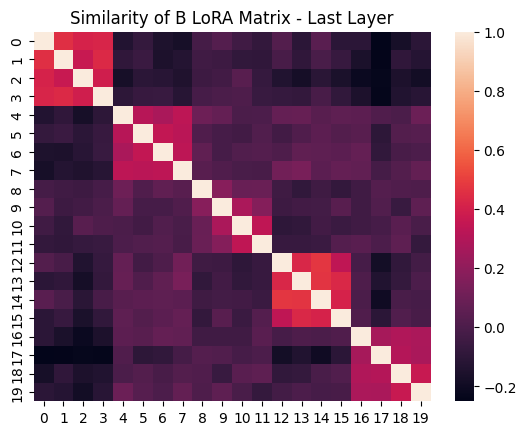

In [64]:
sim = 'output/aya_dataset_400000_clustered_c20s2_i100_b16a1_l512_r8a16_20240913122148/similarity_B_round50.npy'
sim = np.load(sim)
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(sim)
plt.title('Similarity of B LoRA Matrix - Last Layer')

Text(0.5, 1.0, 'Similarity of A LoRA Matrix - Last Layer')

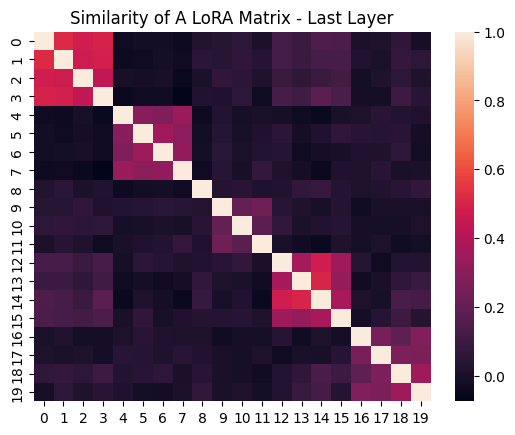

In [63]:
sim = 'output/aya_dataset_400000_clustered_c20s2_i100_b16a1_l512_r8a16_20240913122148/similarity_A_round50.npy'
sim = np.load(sim)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(sim)
plt.title('Similarity of A LoRA Matrix - Last Layer')